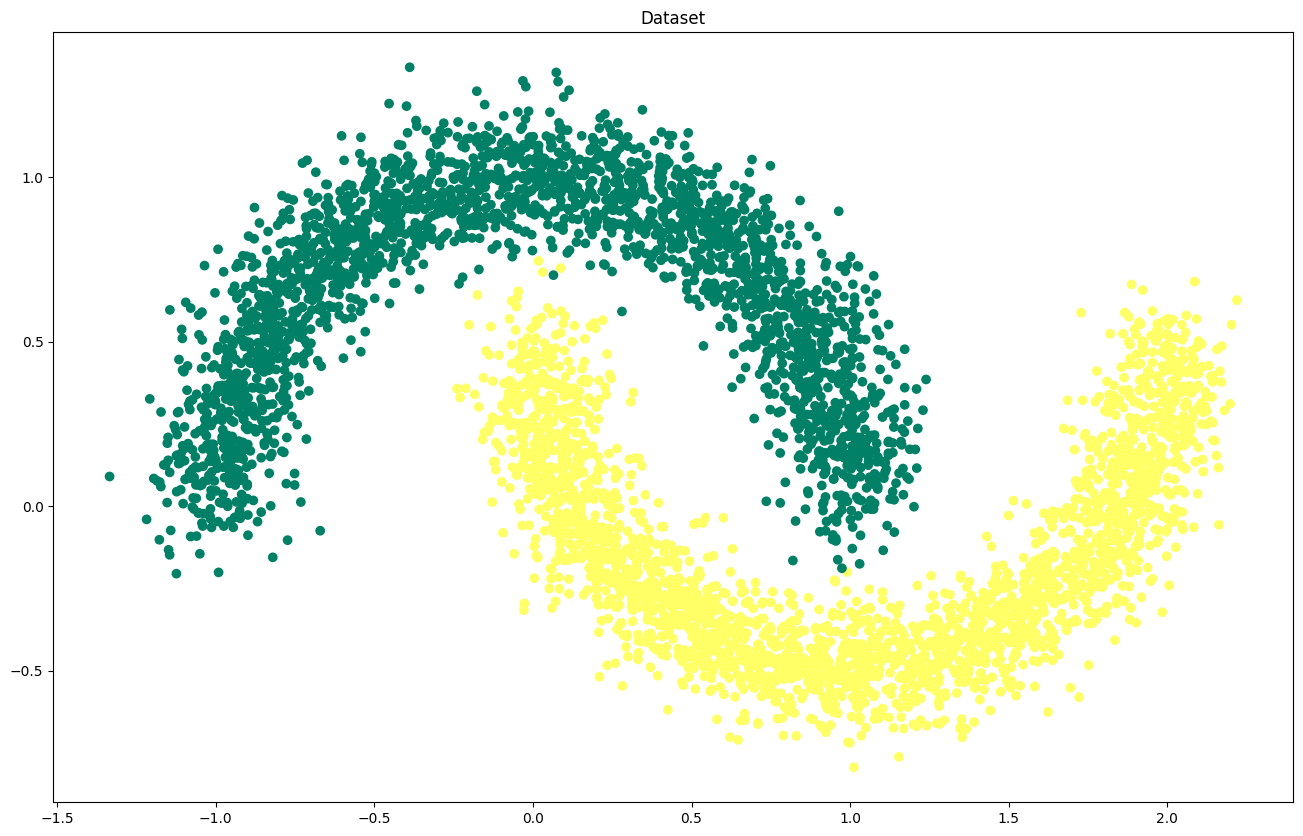

In [2]:
from sklearn.datasets import make_moons
from matplotlib import pyplot as plt
X, y = make_moons(n_samples=5000, random_state=1, noise=0.1)
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="summer")
plt.show()


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=2)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(4000, 2) (4000,)
(1000, 2) (1000,)


In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader

X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.FloatTensor(Y_train)
X_val_t = torch.FloatTensor(X_test)
y_val_t = torch.FloatTensor(Y_test)
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

In [5]:
from torch import nn

class LinearRegression(nn.Module):
 def __init__(self, in_features: int, out_features: int, bias: bool = True):
    super().__init__()
    self.weights = nn.Parameter(torch.Tensor(in_features, out_features))
    self.bias = bias
    
    if bias:
        self.bias_term = nn.Parameter(torch.randn(out_features))

 def forward(self, x):
    x = x@self.weights
    
    if self.bias:
        x += self.bias_term
    
    return x   

In [118]:
linear_regression = LinearRegression(2, 1)

loss_function = nn.KLDivLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.1)

list(linear_regression.parameters())

[Parameter containing:
 tensor([[1.1641e-13],
         [1.1841e-42]], requires_grad=True),
 Parameter containing:
 tensor([-0.0786], requires_grad=True)]

In [119]:
N = 50
tol = 1e-8

loss_function = nn.BCEWithLogitsLoss()

losses = []
max_epochs = 5*N
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False

for epoch in range(max_epochs):
	for it, (X_batch, y_batch) in enumerate(train_dataloader):
		optimizer.zero_grad()
		outp = linear_regression.forward(X_batch).squeeze(1)
		loss = loss_function(outp, y_batch)
		loss.backward()
		losses.append(loss.detach().item())
		optimizer.step()
		
		probabilities = linear_regression.forward(X_batch)
		preds = (torch.sigmoid(probabilities) > 0.5).type(torch.long)
		batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum()/y_batch.size(0)
		
		if it % 10 == 0:
			print(f"Iteration: {it + epoch*len(train_dataloader)}\nBatch accuracy: {batch_acc}")
	
		current_weights = linear_regression.weights.detach().clone()
		if (prev_weights - current_weights).abs().max() < tol:
			print(f"\nIteration: {it + epoch*len(train_dataloader)}. Convergence. Stopping iterations.")
			stop_it = True
			break
		prev_weights = current_weights
	
	if stop_it:
		break

Iteration: 0
Batch accuracy: 0.4921875
Iteration: 10
Batch accuracy: 0.8125
Iteration: 20
Batch accuracy: 0.78125
Iteration: 30
Batch accuracy: 0.84375
Iteration: 32
Batch accuracy: 0.8203125
Iteration: 42
Batch accuracy: 0.8125
Iteration: 52
Batch accuracy: 0.7890625
Iteration: 62
Batch accuracy: 0.84375
Iteration: 64
Batch accuracy: 0.8203125
Iteration: 74
Batch accuracy: 0.8203125
Iteration: 84
Batch accuracy: 0.796875
Iteration: 94
Batch accuracy: 0.84375
Iteration: 96
Batch accuracy: 0.8203125
Iteration: 106
Batch accuracy: 0.84375
Iteration: 116
Batch accuracy: 0.8046875
Iteration: 126
Batch accuracy: 0.84375
Iteration: 128
Batch accuracy: 0.8203125
Iteration: 138
Batch accuracy: 0.84375
Iteration: 148
Batch accuracy: 0.8046875
Iteration: 158
Batch accuracy: 0.859375
Iteration: 160
Batch accuracy: 0.84375
Iteration: 170
Batch accuracy: 0.8515625
Iteration: 180
Batch accuracy: 0.8203125
Iteration: 190
Batch accuracy: 0.859375
Iteration: 192
Batch accuracy: 0.8515625
Iteration: 202

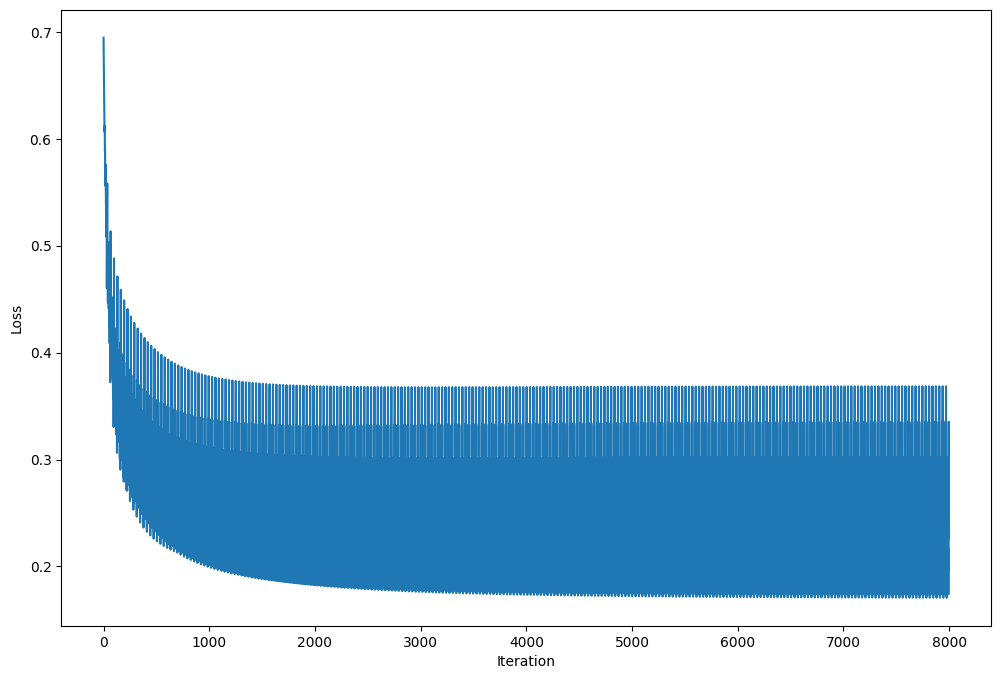

In [120]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [121]:
import numpy as np
def predict(dataloader, model):
	model.eval()
	predictions = np.array([])
	for x_batch, _ in dataloader:
		outp = model(x_batch)
		probs = torch.sigmoid(outp)
		preds = (probs > 0.5).type(torch.long)
		predictions = np.hstack((predictions, preds.numpy().flatten()))

	return predictions.flatten()

from sklearn.metrics import accuracy_score

print(accuracy_score(predict(val_dataloader, linear_regression),Y_test))

0.886
